### Шаг 1. Общая информация <span style="color:green;font-size:200%">&#10003;</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

calls_df = pd.read_csv('/datasets/calls.csv')
net_df = pd.read_csv('/datasets/internet.csv')
messages_df = pd.read_csv('/datasets/messages.csv')
tariffs_df = pd.read_csv('/datasets/tariffs.csv')
users_df = pd.read_csv('/datasets/users.csv')

In [2]:
for df in [calls_df, net_df, messages_df, tariffs_df, users_df]:
    print(df.info(), '\n')
    print(df.head(), '\n')
    print(df.describe(), '\n', '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None 

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000 

            duration        user_id
count  202607.000000  202607.000000
mean        6.755887    1253.940619
std         5.843365     144.722751
min         0.000000    1000.000000
25%         1.300000    1126.000000
50%         6.000000    1260.000000
75%        10.700000    1379.000000
max        38.000000    1499.000000 
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 c

### Шаг 2. Подготовка данных <span style="color:green;font-size:200%">&#10003;</span>

Приводим данные к нужному виду:

In [3]:
for df in [calls_df, net_df, messages_df, tariffs_df, users_df]:
    for col in df.columns:
        if '_date' in col:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.3+ KB


«Мегалайн» всегда округляет вверх значения минут и мегабайтов.

In [4]:
calls_df['duration'] = calls_df['duration'].apply(np.ceil).astype('int')
net_df['mb_used'] = net_df['mb_used'].apply(np.ceil).astype('int')

Посмотрим на графики значений в таблицах calls_df и internet_df:

0.19551644316336553
0.13118155773916304


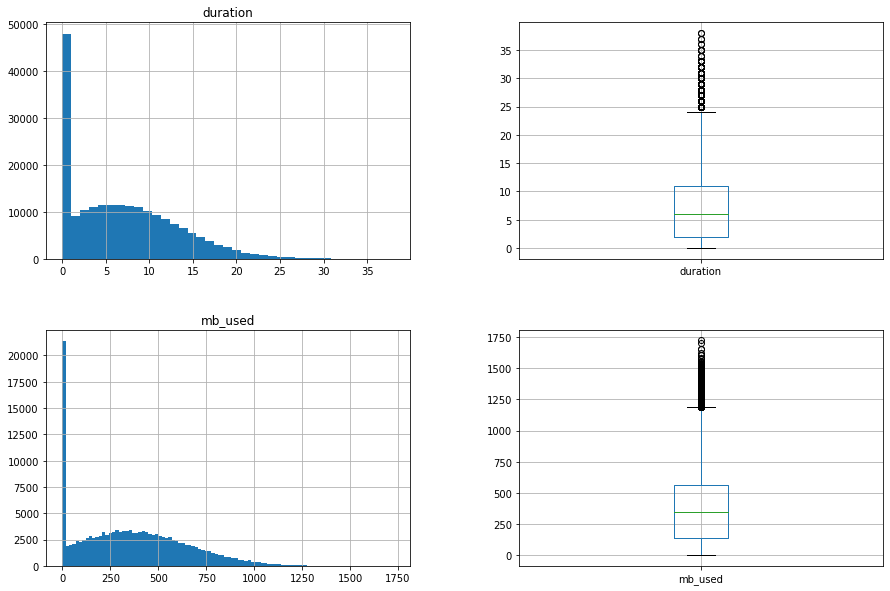

In [5]:
plt.subplots(figsize=(15, 10))
plot = calls_df.hist('duration', bins=37, ax=plt.subplot(2, 2, 1))
plot = calls_df.boxplot('duration', ax=plt.subplot(2, 2, 2))
plot = net_df.hist('mb_used', bins=100, ax=plt.subplot(2, 2, 3))
plot = net_df.boxplot('mb_used', ax=plt.subplot(2, 2, 4))

print(len(calls_df.query('duration == 0')) / len(calls_df))
print(len(net_df.query('mb_used == 0')) / len(net_df))

Звонков с 0 минут целых 20%, а нулевого трафика 13%.

In [6]:
calls_df['user_id'].value_counts().head(3)

1377    1760
1168    1692
1375    1560
Name: user_id, dtype: int64

In [7]:
for maxx in calls_df['user_id'].value_counts().head(3).index:
    print(calls_df.query('user_id == @maxx').shape[0], calls_df.query('user_id == @maxx and duration == 0').shape[0])
    print(calls_df.query('user_id == @maxx and duration == 0').shape[0] / calls_df.query('user_id == @maxx').shape[0])

1760 336
0.19090909090909092
1692 308
0.18203309692671396
1560 290
0.1858974358974359


In [8]:
for maxx in net_df['user_id'].value_counts().head(3).index:
    print(net_df.query('user_id == @maxx').shape[0], net_df.query('user_id == @maxx and mb_used == 0').shape[0])
    print(net_df.query('user_id == @maxx and mb_used == 0').shape[0] / net_df.query('user_id == @maxx').shape[0])

834 141
0.16906474820143885
812 121
0.14901477832512317
789 144
0.18250950570342206


Вообще если присмотреться вероятность получить 0, при возрастании количества звонков и подключений к сети как раз приближается к 20% и 13% соответственно. Мне кажется это указывает на систематичность ошибки, возможно ее выдает алгоритм собирающий информацию. А возможно и сама сеть оператора чудит.

Избавимся от выбросов:<br><br>Правило 3х сигм действительно для нормального распределения, в данном случае распределение Пуассоновское, поэтому обрезать будем по усам ящика.

In [9]:
def cut_junk(df):
    
    for col in df:
        if col == 'duration' or col == 'mb_used':
            
            q3 = df[col].describe()['75%']
            q1 = df[col].describe()['25%']
            iqr = q3 - q1

            return df.loc[(df[col] >= np.floor(q1 - 1.5 * iqr)) & (df[col] <= np.ceil(q3 + 1.5 * iqr))]

In [10]:
calls_df = cut_junk(calls_df)
net_df = cut_junk(net_df)

Нули сделаем невидимыми:

In [11]:
calls_df.loc[calls_df['duration'] == 0, 'duration'] = np.nan
net_df.loc[net_df['mb_used'] == 0, 'mb_used'] = np.nan

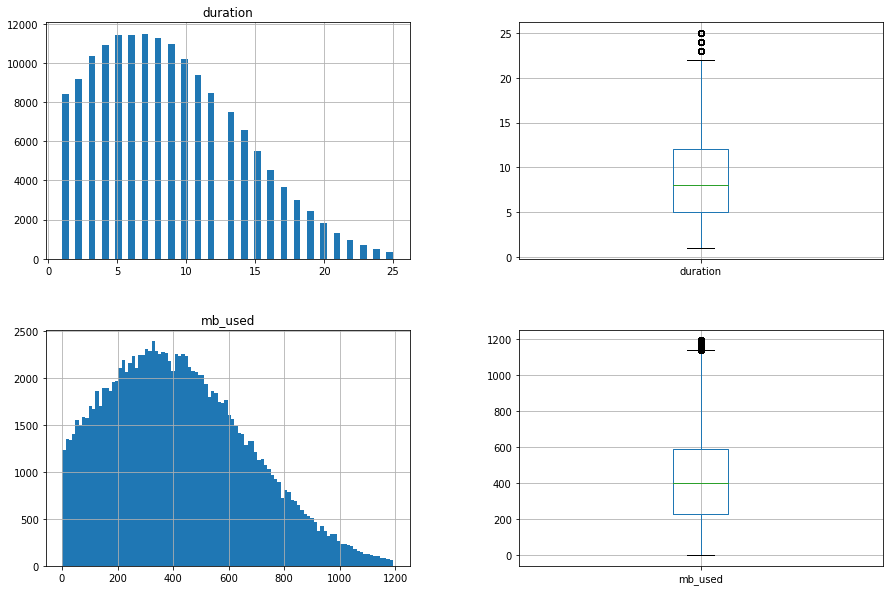

In [12]:
plt.subplots(figsize=(15, 10))
plot = calls_df.hist('duration', bins=50, ax=plt.subplot(2, 2, 1))
plot = calls_df.boxplot('duration', ax=plt.subplot(2, 2, 2))
plot = net_df.hist('mb_used', bins=100, ax=plt.subplot(2, 2, 3))
plot = net_df.boxplot('mb_used', ax=plt.subplot(2, 2, 4))

In [13]:
for df in [calls_df, net_df, messages_df]:
    for col in df.columns:
        if '_date' in col:
            df['month'] = df[col].dt.month
            
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201929 entries, 0 to 202606
Data columns (total 5 columns):
id           201929 non-null object
call_date    201929 non-null datetime64[ns]
duration     162316 non-null float64
user_id      201929 non-null int64
month        201929 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.2+ MB


Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:

In [14]:
minutes_sum = calls_df.pivot_table(index=['user_id', 'month'], aggfunc={'duration':'sum', 'id':'count'})
minutes_sum.set_axis(['minutes', 'calls'], axis='columns', inplace=True)
minutes_sum.sample(5)

,,minutes,calls
user_id,month,,
1458,10,855.0,122
1331,7,537.0,81
1005,9,479.0,66
1116,10,339.0,50
1006,3,286.0,46


Посчитаем количество отправленных сообщений по месяцам для каждого пользователя:

In [15]:
messages_sum = messages_df.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_sum.set_axis(['sms'], axis='columns', inplace=True)
messages_sum.sample(5)

,,sms
user_id,month,
1486,12,83
1058,11,27
1027,11,9
1144,11,51
1288,12,60


Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя:

In [16]:
mb_sum = net_df.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
mb_sum = np.ceil(mb_sum / 1024)
mb_sum.set_axis(['gb_used'], axis='columns', inplace=True)
mb_sum.sample(3)

,,gb_used
user_id,month,
1089,4,14.0
1188,11,11.0
1219,12,17.0


In [17]:
res_sum = minutes_sum.join([messages_sum, mb_sum], how='outer')
res_sum.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 4 columns):
minutes    3174 non-null float64
calls      3174 non-null float64
sms        2717 non-null float64
gb_used    3203 non-null float64
dtypes: float64(4)
memory usage: 114.0 KB


Посчитаем помесячную выручку с каждого пользователя:

In [18]:
users_df = users_df.set_index('user_id')
res_sum = res_sum.merge(users_df['tariff'], left_index=True, right_index=True)

res_sum.head(1)

,,minutes,calls,sms,gb_used,tariff
user_id,month,,,,,
1000,5,159.0,22.0,22.0,3.0,ultra


In [19]:
tariffs_df.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [20]:
def gimme_your_money(row):
    
    key = row['tariff']
    tariff = tariffs_df.loc[tariffs_df['tariff_name'] == key]

    
    if row['minutes'] > int(tariff['minutes_included']):
        minutes_pay = int((row['minutes'] - tariff['minutes_included']) * tariff['rub_per_minute'])
    else:
        minutes_pay = 0
    
    
    if row['sms'] > int(tariff['messages_included']):
        msg_pay = int((row['sms'] - tariff['messages_included']) * tariff['rub_per_message'])
    else:
        msg_pay = 0
    
    
    if row['gb_used'] > int(np.ceil(tariff['mg_per_month_included'] / 1024)):
        net_pay = int((row['gb_used'] - np.ceil(tariff['mg_per_month_included'] / 1024)) * tariff['rub_per_gb'])
    else:
        net_pay = 0
        
        
    month_pay = minutes_pay + msg_pay + net_pay + int(tariff['rub_monthly_fee'])
        
    return month_pay

In [21]:
res_sum['month_pay'] = res_sum.apply(gimme_your_money, axis=1)
res_sum['calls'] = res_sum['calls'].fillna(0).astype('int')
res_sum.describe()

,minutes,calls,sms,gb_used,month_pay
count,3174.000000,3214.000000,2717.000000,3203.000000,3214.000000
mean,451.018589,62.827940,45.283769,17.172338,1511.327940
std,234.947265,33.130371,35.051363,7.191215,783.819673
min,0.000000,0.000000,1.000000,0.000000,550.000000
25%,286.000000,40.000000,19.000000,13.000000,750.000000
50%,440.500000,62.000000,38.000000,17.000000,1591.000000
75%,585.000000,82.000000,63.000000,21.000000,1950.000000
max,1583.000000,240.000000,224.000000,45.000000,6692.000000


Месяцы, где сумма минут и гб для абонента равна 0 преобразуем в Nan, чтобы уменьшить их влияние. А вот количество звонков может быть равно нулю.

### Шаг 3. <span style="color:green;font-size:200%">&#10003;</span>

gb_used                  minutes                       sms  \
tariff        smart       ultra        smart        ultra        smart   
count   2228.000000  975.000000  2223.000000   951.000000  1922.000000   
mean      16.277828   19.216410   413.734143   538.172450    38.716441   
std        5.721850    9.441234   186.839934   303.086359    26.787949   
min        0.000000    0.000000     0.000000     0.000000     1.000000   
25%       13.000000   12.000000   280.000000   308.500000    17.000000   
50%       17.000000   19.000000   415.000000   519.000000    34.000000   
75%       20.000000   26.000000   540.000000   752.000000    55.000000   
max       38.000000   45.000000  1435.000000  1583.000000   143.000000   

                    
tariff       ultra  
count   795.000000  
mean     61.161006  
std      45.931026  
min       1.000000  
25%      24.000000  
50%      51.000000  
75%      87.500000  
max     224.000000

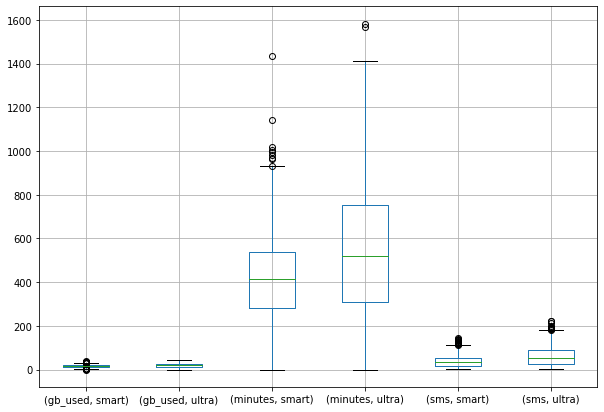

In [22]:
res_tariff_pivot = res_sum.pivot_table(index=['user_id', 'month'], columns='tariff', values=['minutes', 'sms', 'gb_used'])
res_tariff_pivot.boxplot(figsize=(10, 7))
res_tariff_pivot.describe()

#### Звонки:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5ab36748>,
      dtype=object)

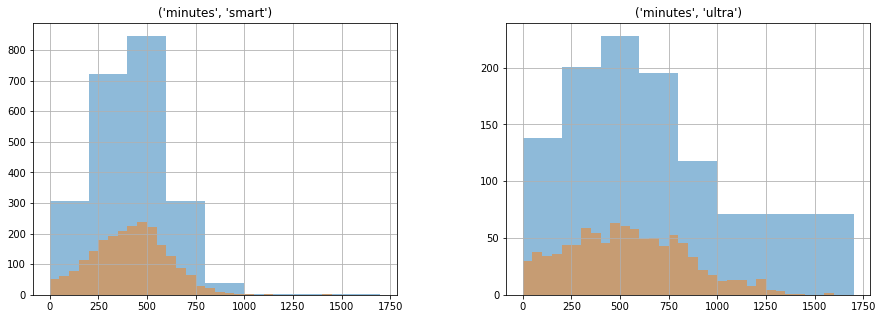

In [23]:
ax = res_tariff_pivot.hist('minutes', bins=[0, 200, 400, 600, 800, 1000, 1700], alpha=0.5, figsize=(15, 5))
res_tariff_pivot.hist('minutes', bins=list(range(0, 1700, 50)), alpha=0.5, ax=ax, figsize=(15, 5))

#### Интернет

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b5aa2ada0>,
      dtype=object)

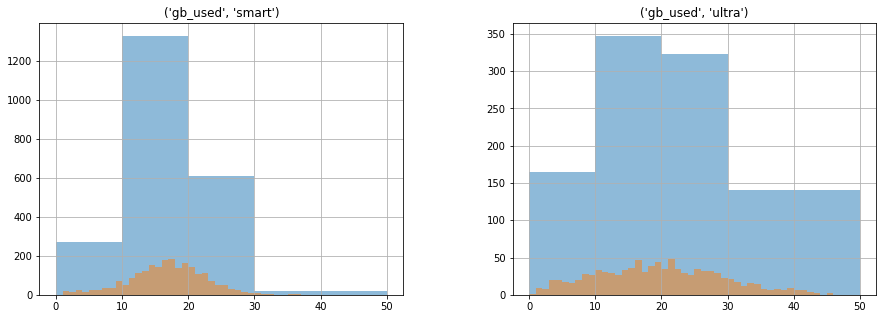

In [24]:
ax = res_tariff_pivot.hist('gb_used', bins=[0, 10, 20, 30, 50], alpha=0.5, figsize=(15, 5))
res_tariff_pivot.hist('gb_used', bins=list(range(0, 50)), alpha=0.5, ax=ax, figsize=(15, 5))

#### СМС

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b603ed160>,
      dtype=object)

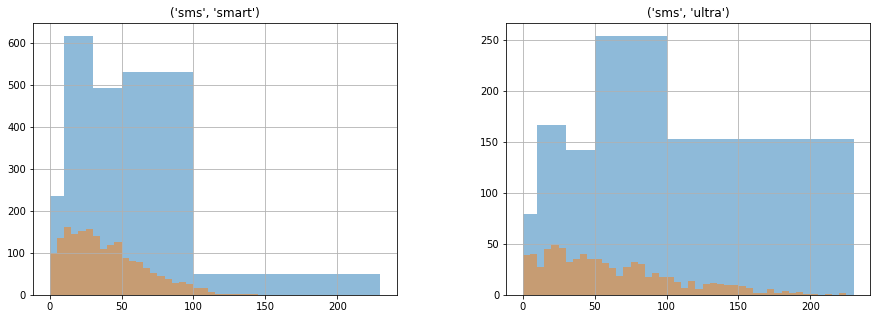

In [25]:
ax = res_tariff_pivot.hist('sms', bins=[0, 10, 30, 50, 100, 230], alpha=0.5, figsize=(15, 5))
res_tariff_pivot.hist('sms', bins=list(range(0, 230, 5)), alpha=0.5, ax=ax, figsize=(15, 5))

Дополним вывод describe значением дисперсии:

In [26]:
res_describe = res_tariff_pivot.describe()
res_describe.loc['var'] = np.var(res_tariff_pivot)
res_describe

gb_used                   minutes                        sms  \
tariff        smart       ultra         smart         ultra        smart   
count   2228.000000  975.000000   2223.000000    951.000000  1922.000000   
mean      16.277828   19.216410    413.734143    538.172450    38.716441   
std        5.721850    9.441234    186.839934    303.086359    26.787949   
min        0.000000    0.000000      0.000000      0.000000     1.000000   
25%       13.000000   12.000000    280.000000    308.500000    17.000000   
50%       17.000000   19.000000    415.000000    519.000000    34.000000   
75%       20.000000   26.000000    540.000000    752.000000    55.000000   
max       38.000000   45.000000   1435.000000   1583.000000   143.000000   
var       32.724876   89.045474  34893.457435  91764.746286   717.220843   

                     
tariff        ultra  
count    795.000000  
mean      61.161006  
std       45.931026  
min        1.000000  
25%       24.000000  
50%       51.000000  
75%       87.500000  
max      224.000000  
var     2107.005524

Исходя из полученных графиков можно судить о среднестатистическом пользователе конкретного тарифа:<br>

Пользователь тарифа "Смарт":

    1) Хотя по смещению гистограммы видно, что подавляющее большинство людей контролирует расход минут, все же 500 минут нехватает, самый пик в диапазоне от 400 до 600 минут в месяц. Среднее и медиана в данном случае почти равны ~ 400 мин. Предоставленый ресурс используется по максимуму и велик риск переплаты.

    2) По статистике использования интеренета видно, что его не хватает. Среднее и медиана ~ 16 это уже превышает лимит, гистограмма смещена вправо 10 - 30 гб, среднестатистическому пользователю не хватает 15гб в месяц.

    3) По смс можно видеть, что среднестатистический пользователь не отправляет больше 100 смс в месяц. Чего опять же нехватает в тарифе "смарт"

Пользователь тарифа "Ультима":

    1) В этом тарифе вообще распределение более горизонтальное, большой разброс, что видно по std. Стреднестатистический пользователь этого тарифа расходует от 200 до 750 минут в месяц. Среднее и медиана здесь немного различаются, медиана здесь меньше, датасет немного скошен вправо. Среднестатистическому пользователю никак не получается выговорить 3000 минут в месяц.

    2) Здесь тоже можно наблюдать как растянулись значения по оси, хотя отведенного лимита здесь чаще хватает. Среднее 18 и медиана 19 гб. 

    3) Пользователи чаще отправляют смс, покольку лимит позваляет, но среднестатистический редко использьует больше 100 в месяц.


Дисперсия отражает разброс величин относительно среднего, что тоже заметно по гистограмме, чем более острый график, тем ниже дисперсия.<br>
Как и более узкие рамки гистограммы уменьшают дисперсию, так и больший лимит резурсов в тарифе размазывает эту гистограмму.

### Шаг 4. <span style="color:green;font-size:200%">&#10003;</span>

    Проверить гипотезу - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются:

In [27]:
from scipy import stats as st

mean_user_pay = res_sum.pivot_table(index='user_id', columns='tariff', values='month_pay')
smart_user_pay = mean_user_pay['smart'].dropna()
ultra_user_pay = mean_user_pay['ultra'].dropna()
mean_user_pay.describe()

tariff,smart,ultra
count,350.000000,148.000000
mean,1307.141565,2066.336580
std,597.412802,260.953492
min,550.000000,1950.000000
25%,854.950000,1950.000000
50%,1160.333333,1950.000000
75%,1650.000000,1953.125000
max,4307.333333,3075.000000


Вроде отличается...<br>
Это гипотеза о равенстве двух генеральных совокупностей<br>
H0 должна звучать как-то так - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается, а значит равны!<br>H1 соответственно будет говорить о том что выручки у нас различаются. Ставлю все на H1.

In [28]:
#Критический уровень:
alpha = 0.0001

results = st.ttest_ind(smart_user_pay, ultra_user_pay)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3244838989633962e-41
Отвергаем нулевую гипотезу


Выручки различаются даже при alpha в 0.01%. Результат говорит о том что средняя выручка с абонента тарифа смарт в месяц никак не может сравниться с выручкой от тарифа ультра, даже случайно. Разница на лицо.

    Проверить гипотезу - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

H0 - средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов, а значит равна!<br>
H1 гласит, что выручка в Москве и регионах отличаются.

In [29]:
city_user_pay = res_sum.pivot_table(index='user_id', values='month_pay')
city_user_pay = city_user_pay.join(users_df['city'], how='left')
city_user_pay['city'] = city_user_pay['city'].where(city_user_pay['city'] == 'Москва', 'Другой')
city_user_pay = city_user_pay.pivot_table(index='user_id', columns='city')
city_user_pay.set_axis(['region', 'moscow'], axis='columns', inplace=True)
city_user_pay.describe()

,region,moscow
count,399.000000,99.000000
mean,1545.043820,1483.281592
std,633.046072,595.231944
min,550.000000,550.000000
25%,990.000000,959.150000
50%,1555.000000,1618.285714
75%,1950.000000,1950.000000
max,4307.333333,2896.500000


In [30]:
alpha = 0.0001

results = st.ttest_ind(city_user_pay['region'].dropna(), city_user_pay['moscow'].dropna())

print('p-значение: ', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3798066262179839
Не получилось отвергнуть нулевую гипотезу


Средняя выручка абонентов в Москве и Регионах практически не отличается. 38% что различие в выручке случайно, это очень значительно. 

### Вывод <span style="color:green;font-size:200%">&#10003;</span>

Пользователей тарифа "Смарт" от пользователей тарифа "Ультра" отличает диапазон используемого ресурса, что хорошо видно по разбросу значений, по характеристикам стандартного отклонения и десперсии.<br><br>
У пользователей тарифа "Ультра" лимит, и тем не менее средний пользователь тарифа тарифа "Смарт" не многим отличается от пользователя тарифа "Ультра".<br>
Они расходуют примерно одинаковое количество минут в месяц, хотя у пользователей тарифа "Ультра все же диапазон шире, пользователи тарифа "Смарт" зачастую превышают лимит.<br>
Тоже самое можно наблюдать и с кол-вом гб в месяц.<br><br>
Гипотиза, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются подтвердилась, несмотря на то что пользователи тарифа "Смарт" часто вынуждены переплачивать.<br>
А гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, наоборот не подтвердилась, несмотря на большую популярность компании "Мегалайн" в регионах.<br><br>
Продвигать стоит тариф "Ультра".